Ref: https://ai.plainenglish.io/what-are-the-transformers-2569e5cad2af

We will now code the other building blocks of an LLM and assemble them into a GPT-like model that we will train in the next chapter to generate human-like text

<img src="./images/13_project_stage.png" width="500px">

A mental model of GPT


<img src="./images/13_mental_model_gpt.png" width="500px">

This is what we are going to cover:

<img src="./images/13_gpt_arch_building_blocks.png" width="400px">

In [33]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.9.2
torch version: 2.5.1
tiktoken version: 0.8.0


- Models like GPT and Llama, which generate words sequentially and are based on the decoder part of the original transformer architecture
- Therefore, these LLMs are often referred to as "decoder-like" LLMs
- Compared to conventional deep learning models, LLMs are larger, mainly due to their vast number of parameters, not the amount of code
- We'll see that many elements are repeated in an LLM's architecture

- In this section, we consider embedding and model sizes akin to a small GPT-2 model
- We'll specifically code the architecture of the smallest GPT-2 model (124 million parameters), as outlined in Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) (note that the initial report lists it as 117M parameters, but this was later corrected in the model weight repository)
- In the later project, we will show how to load pretrained weights into our implementation, which will be compatible with model sizes of 345, 762, and 1542 million parameters

- Configuration details for the 124 million parameter GPT-2 model include:

In [34]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- We use short variable names to avoid long lines of code later
- `"vocab_size"` indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer
- `"context_length"` represents the model's maximum input token count, as enabled by positional embeddings
- `"emb_dim"` is the embedding size for token inputs, converting each input token into a 768-dimensional vector
- `"n_heads"` is the number of attention heads in the multi-head attention mechanism
- `"n_layers"` is the number of transformer blocks within the model
- `"drop_rate"` is the dropout mechanism's intensity; 0.1 means dropping 10% of hidden units during training to mitigate overfitting
- `"qkv_bias"` decides if the `Linear` layers in the multi-head attention mechanism should include a bias vector when computing query (Q), key (K), and value (V) tensors; we'll disable this option, which is standard practice in modern LLMs; however, we'll revisit this later when loading pretrained GPT-2 weights from OpenAI into our reimplementation

In [35]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        print("Token Embeddings: \n", tok_embeds)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        print("Position Embeddings: \n", pos_embeds)
        x = tok_embeds + pos_embeds
        print("Token + Position Embeddings: \n", x)
        x = self.drop_emb(x)
        print("After Dropout: \n", x)
        x = self.trf_blocks(x)
        print("After Tansformer: \n", x)
        x = self.final_norm(x)
        print("After normalization: \n", x)
        logits = self.out_head(x)
        print("Output logits: \n", logits)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

- The `DummyGPTModel` class in this code defines a simplified version of a GPT-like model using PyTorch's neural network module (`nn.Module`). The model architecture in the `DummyGPTModel` class consists of token and positional embeddings, dropout, a series of transformer blocks (`DummyTransformerBlock`), a final layer normalization (`DummyLayerNorm`), and a linear output layer (`out_head`). The configuration is passed in via a Python dictionary, for instance, the `GPT_CONFIG_124M` dictionary we created
earlier.

- The `forward` method describes the data flow through the model: it computes token and positional embeddings for the input indices, applies dropout, processes the data through the transformer blocks, applies normalization, and finally produces logits with the linear output layer.

- However, for now, note in the code above that we have used placeholders (`DummyLayerNorm` and `DummyTransformerBlock`) for the transformer block and layer normalization, which we will develop in later sections.

A big-picture overview showing how the input data is tokenized, embedded, and fed to the GPT model. Note that in our `DummyGPTClass` coded earlier, the token embedding is handled inside the GPT model. In LLMs, the embedded input token dimension typically matches the
output dimension. The output embeddings here represent the context vectors.

<img src="./images/13_gpt_big_pic.png" width="500px">

In [36]:
# we tokenize a batch consisting of two text inputs for the GPT model using the tiktoken tokenizer
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print("The resulting token IDs for the two texts are:\n", batch)

The resulting token IDs for the two texts are:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [37]:
# Next, we initialize a new 124 million parameter DummyGPTModel instance and feed it the tokenized batch:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Token Embeddings: 
 tensor([[[ 1.6146,  2.1622,  1.2770,  ...,  0.0111, -1.1353, -0.2450],
         [-1.6020, -1.3996,  0.4308,  ...,  0.0913, -0.0614, -0.0538],
         [ 0.7265,  1.0869, -0.2251,  ..., -0.0742,  0.1081,  0.9774],
         [-0.4047, -0.0914, -1.5747,  ..., -1.5130,  0.4232,  0.5841]],

        [[ 1.6146,  2.1622,  1.2770,  ...,  0.0111, -1.1353, -0.2450],
         [-0.7858,  0.0101,  1.2537,  ..., -0.2667, -0.7853,  1.3047],
         [ 1.8873,  0.7559, -0.1797,  ..., -0.0418, -0.4365, -0.3167],
         [ 1.2758, -0.2896,  0.9539,  ...,  0.3405, -1.0636, -0.0674]]],
       grad_fn=<EmbeddingBackward0>)
Position Embeddings: 
 tensor([[ 0.8769,  0.2550,  0.8441,  ..., -1.0354,  1.3085,  1.7957],
        [-1.0029,  0.0995,  1.2459,  ...,  1.5453, -0.1126, -1.5197],
        [ 1.3317,  0.7561,  0.9077,  ...,  0.0830,  1.8336, -2.2225],
        [-1.2565, -2.0294, -1.3685,  ...,  1.8521,  0.5519,  0.8279]],
       grad_fn=<EmbeddingBackward0>)
Token + Position Embeddings: 


- The above output tensor (`torch.Size([2, 4, 50257])`) has two rows corresponding to the two text samples. Each text sample consists of 4 tokens/words; each token is a 50,257-dimensional vector, which matches the size of the tokenizer's vocabulary.

- The embedding has 50,257 dimensions because each of these dimensions refers to a unique token in the vocabulary

## Normalizing activations with layer normalization

<img src="./images/13_layer_norm_pic.png" width="200px">

- Layer normalization, also known as LayerNorm ([Ba et al. 2016](https://arxiv.org/abs/1607.06450)), centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1
- This stabilizes training and enables faster convergence to effective weights
- Layer normalization (based on the `DummyLayerNorm` placeholder function) is applied both before and after the multi-head attention module within the transformer block, which we will implement later; it's also applied before the final output layer

<img src="./images/13_layer_norm.png" width="500px">

We apply Layer normalization for better training purpose. This is to avoid vanishing gradient descent during the backpropogation. 

<img src="./images/13_layer_norm_walkthru.png" width="800px">

- Typically these activations of these neurons will be a wide range of +ve and -ve values. Normalization encapsulates these values within a much smaller range and typically centered around 0.
- What this allows for is much more stable training during the backpropogation phase, esp when taking gradient steps, we are taking much more even steps for easier to learn. 
- Layer Normalization is a strategy we apply for neural network. Here, in every layer (hidden), we tend to apply a mean of 0 and std. deviation of 1.    

- Let's see how layer normalization works by passing a small input sample through a simple neural network layer:

In [38]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- Let's compute the mean and variance for each of the 2 inputs above:

In [39]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- The normalization is applied to each of the two inputs (rows) independently; using *dim=-1* applies the calculation across the last dimension (in this case, the feature dimension) instead of the row dimension

<img src="./images/13_mean_variance.png" width="400px">

- Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension:

In [40]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Each input is centered at 0 and has a unit variance of 1; to improve readability, we can disable PyTorch's scientific notation:

In [41]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Above, we normalized the features of each input
- Now, using the same idea, we can implement a `LayerNorm` class:

In [42]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        print("Input: \n", x)
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        print(f"mean:{mean} \n variance:{var} \n normalization: {norm_x}")
        return self.scale * norm_x + self.shift #(i.e. alpha * norm_x + beta, where alpha and beta are trainable parameters)

This specific implementation of layer Normalization operates on the last dimension of the input tensor x, which represents the embedding dimension (`emb_dim`).

**Scale and shift**

- Note that in addition to performing the normalization by subtracting the mean and dividing by the variance, we added two trainable parameters, a `scale` and a `shift` parameter
- The initial `scale` (multiplying by 1) and `shift` (adding 0) values don't have any effect; however, `scale` and `shift` are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task
- This allows the model to learn appropriate scaling and shifting that best suit the data it is processing
- Note that we also add a smaller value, epsilon (`eps`) before computing the square root of the variance; this is to avoid division-by-zero errors if the variance is 0

**Biased variance**
- In the variance calculation above, setting `unbiased=False` means using the formula $\frac{\sum_i (x_i - \bar{x})^2}{n}$ to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses `n-1` in the denominator), thus providing a biased estimate of the variance 
- For LLMs, where the embedding dimension `n` is very large, the difference between using `n` and `n-1`
 is negligible
- We chose this approach to ensure compatibility with the GPT-2 model's normalization layers and because it reflects TensorFlow's default behavior, which was used to implement the original GPT-2 model.



- Let's now try out `LayerNorm` in practice:

In [43]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

Input: 
 tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
mean:tensor([[-0.3596],
        [-0.2606]]) 
 variance:tensor([[0.2015],
        [0.2673]]) 
 normalization: tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]])


In [44]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="./images/13_layer_norm_complete.png" width="400px">

**Layer Normalization versus Batch Normalization**

Batch normalization is a common and traditional normalization method for neural networks which normalizes across the batch dimension, layer normalization normalizes across the feature dimension. LLMs often require significant computational resources, and the available hardware or the specific use case can dictate the batch size during training or inference. 

Since layer normalization normalizes each input independently of the batch size, it offers more flexibility and stability in these scenarios. This is particularly beneficial for distributed training or when deploying models in environments where resources are constrained.

## Implementing a feed forward network with GELU activations

- In this section, we implement a small neural network submodule that is used as part of the transformer block in LLMs
- We start with the activation function
- In deep learning, ReLU (Rectified Linear Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architectures
- In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Sigmoid-Weighted Gated Linear Unit)
- GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU

- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415)) can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
- In practice, it's common to implement a computationally cheaper approximation: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (the original GPT-2 model was also trained with this approximation)

In [45]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

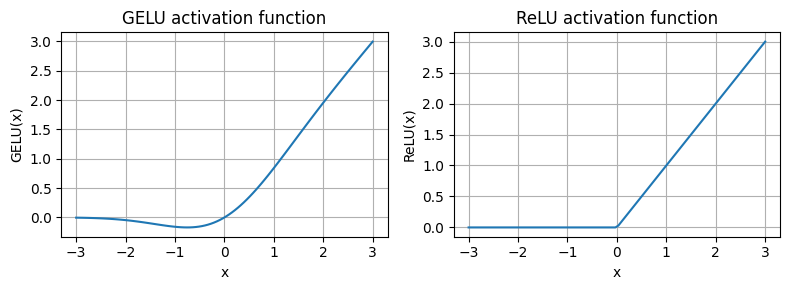

In [46]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- The smoothness of GELU, as shown in the below fig, can lead to better optimization properties during training, as it allows for more nuanced adjustments to the model's parameters. 
- In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder, especially in networks that are very deep or have complex architectures. 
- Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output for negative values. This characteristic means that during the training process, neurons that receive negative input can still contribute to the learning process, albeit to a lesser extent than positive inputs.

<img src="./images/13_gelu_relu_matlab.png" width="500px">

- Next, let's use the GELU function to implement the small neural network module, `FeedForward`, that we will be using in the LLM's transformer block

- In the below code, the `FeedForward` module is a small neural network consisting of two Linear layers and a GELU activation function. 

- In the 124 million parameter GPT model, it receives the input batches with tokens that have an embedding size of 768 each via the `GPT_CONFIG_124M` dictionary where `GPT_CONFIG_124M["emb_dim"] = 768`.

In [47]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [48]:
print(GPT_CONFIG_124M["emb_dim"])

768


The below figure shows how the embedding size is manipulated inside this small feed forward neural network when we pass it some inputs.

<img src="./images/13_feed_fwd_overview.png" width="400px">

let's initialize a new `FeedForward` module with a token embedding size of 768 and feed it a batch input with 2 samples and 3 tokens each:

In [49]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) # input shape: [batch_size, num_token, emb_size]
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


- As we can see above, the shape of the output tensor is the same as that of the input tensor

The `FeedForward` module we implemented in this section plays a crucial role in enhancing the model's ability to learn from and generalize the data. Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higher-dimensional space through the first linear layer as illustrated in below figure. This expansion is followed by a non-linear GELU activation, and then a contraction back to the original dimension with the second linear transformation. Such a design allows for the exploration of a richer representation space.

<img src="./images/13_feed_fwd_linear_layers.png" width="400px">

<img src="./images/13_feed_fwd_complete.png" width="400px">

## Adding shortcut connections

- Next, let's talk about the concept behind shortcut connections, also called skip or residual connections
- Originally, shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems.
    - The vanishing gradient problem refers to the issue where gradients (which guide weight updates during training) become progressively smaller as they propagate backward through the layers, making it difficult to effectively train earlier layers
- A shortcut connection creates an alternative shorter path for the gradient to flow through the network. Shortcut connections involve adding the inputs of a layer to its outputs, effectively creating an alternate path that bypasses certain layers.
- This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between
- Let's illustrate this idea with a small example network:

<img src="./images/13_shortcuts_overview.png" width="500px">

- The code implements a deep neural network with 5 layers, each consisting of a Linear layer and a GELU activation function. In the forward pass, we iteratively pass the input through the layers and optionally add the shortcut connections.

In [50]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- Let's print the gradient values first **without** shortcut connections:

- Here, each layer will be initialized such that it accepts an example with 3 input values and returns 3 output values. The last layer returns a single output value:

In [51]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


- As we can see above, based on the output of the print_gradients function, the gradients become smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which is a phenomenon called the **vanishing gradient problem**.

- Next, let's print the gradient values **with** shortcut connections:

In [52]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


- As we can see above, based on the output, the last layer (layers.4) still has a larger gradient than the other layers. However, the gradient value stabilizes as we progress towards the first layer (layers.0) and doesn't shrink to a vanishingly small value.

Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective training by ensuring consistent gradient flow across layers when we train the GPT model.

Ref: [See Residual Networks and Skip Connections Video](https://www.youtube.com/watch?v=Q1JCrG1bJ-A&t=154s&ab_channel=ProfessorBryce)

We will now connect all of the previously covered concepts (layer normalization, GELU activations, feed forward module, and shortcut connections) in a transformer block.

## Connecting attention and linear layers in a transformer block

<img src="./images/13_transformer_block_illustration.png" width="500px">

- A transformer block combines the causal multi-head attention module from the previous chapter with the linear layers, the feed forward neural network we implemented in an earlier section
- In addition, the transformer block also uses dropout and shortcut connections

- Loading Multi-attention head from the other Jupyter notebook

In [53]:
%run 2.attention_mechanisms.ipynb

torch version: 2.5.1
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Input: 
 tensor([0.4300, 0.1500, 0.8900])
Query: 
 tensor([0.5500, 0.8700, 0.6600]) 

Multiplying query and input array in a normal way 

0.4300000071525574 * 0.550000011920929 = 0.23650000989437103
0.15000000596046448 * 0.8700000047683716 = 0.13050000369548798
0.8899999856948853 * 0.6600000262260437 = 0.5874000191688538
tensor(0.9544)

 Using torch dot product: 
 0.9544000625610352
Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Inputs 
 tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])
Attn Weights 
 tensor([0.1385, 0.2379, 0.2

The given code defines a `TransformerBlock` class in PyTorch that includes a multi-head attention mechanism (`MultiHeadAttention`) and a feed forward network (`FeedForward`), both configured based on a provided configuration dictionary (`cfg`), such as `GPT_CONFIG_124M`.

Layer normalization (`LayerNorm`) is applied before each of these two components, and dropout is applied after them to regularize the model and prevent overfitting. This is also known as **Pre-LayerNorm**. Older architectures, such as the original transformer model, applied layer normalization after the self-attention and feed-forward networks instead, known as **Post-LayerNorm**, which often leads to worse training dynamics.

In [54]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(  
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

- Suppose we have 2 input samples with 6 tokens each, where each token is a 768-dimensional embedding vector; then this transformer block applies self-attention, followed by linear layers, to produce an output of similar size
- You can think of the output as an augmented version of the context vectors we discussed in the previous notebook

In [55]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)


 Init: 
 MultiHeadAttention(
  (W_query): Linear(in_features=768, out_features=768, bias=False)
  (W_key): Linear(in_features=768, out_features=768, bias=False)
  (W_value): Linear(in_features=768, out_features=768, bias=False)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Query weight: 
 Parameter containing:
tensor([[-0.0209,  0.0120, -0.0163,  ..., -0.0051, -0.0039, -0.0334],
        [-0.0050,  0.0327, -0.0230,  ..., -0.0048, -0.0006, -0.0130],
        [ 0.0070, -0.0057, -0.0128,  ...,  0.0304,  0.0100, -0.0328],
        ...,
        [ 0.0037,  0.0139, -0.0252,  ...,  0.0143,  0.0299,  0.0167],
        [ 0.0067, -0.0124,  0.0217,  ...,  0.0014,  0.0047,  0.0005],
        [-0.0184, -0.0177,  0.0029,  ...,  0.0267,  0.0287,  0.0036]],
       requires_grad=True)
Input: 
 tensor([[[0.2961, 0.5166, 0.2517,  ..., 0.9541, 0.8567, 0.4604],
         [0.2238, 0.3047, 0.3019,  ..., 0.5465, 0.4532, 0.7598],
         [0.6945, 0.2

<img src="./images/13_transformer_block_complete.png" width="400px">

## Coding the GPT Model

- We are almost there: now let's plug in the transformer block into the architecture we coded at the very beginning of this chapter so that we obtain a usable GPT architecture

- An overview of the GPT model architecture. This figure illustrates the flow of data through the GPT model. Starting from the bottom, tokenized text is first converted into token embeddings, which are then augmented with positional embeddings. This combined information
forms a tensor that is passed through a series of transformer blocks shown in the center (each containing multi-head attention and feed forward neural network layers with dropout and layer normalization), which are stacked on top of each other and repeated 12 times.

<img src="./images/13_gpt_model_arch.png" width="500px">

- The __init__ constructor of this GPTModel class does the following:
    - initializes the token and positional embedding layers using the configurations passed in via a Python dictionary, `cfg`. These embedding layers are responsible for converting input token indices into dense vectors and adding positional information.
    - Creates a sequential stack of `TransformerBlock` modules equal to the number of layers specified in `cfg`.
    - Following the transformer blocks, a `LayerNorm` layer is applied, standardizing the outputs from the transformer blocks to stabilize the learning process.
    - A linear output head without bias is defined, which projects the transformer's output into the vocabulary space of the tokenizer to generate logits for each token in the vocabulary.  

- The `forward` method takes a batch of input token indices, computes their embeddings, applies the positional embeddings, passes the sequence through the transformer blocks, normalizes the final output, and then computes the logits, representing the next token's unnormalized probabilities.

- The corresponding code implementation, where `cfg["n_layers"] = 12`:

In [82]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        print("config: \n", cfg)
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):        
        batch_size, seq_len = in_idx.shape
        print(f"in_idx.shape: {in_idx.shape} \n in_idx: {in_idx}\n")
        tok_embeds = self.tok_emb(in_idx)
        print("Token Embeddings: \n", tok_embeds)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        print("Pos Embeddings: \n", pos_embeds)
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        print("Token + Pos Embeddings: \n", x)
        x = self.drop_emb(x)
        print("After Dropout: \n", x)
        x = self.trf_blocks(x)
        print("After Transform blocks: \n", x)
        x = self.final_norm(x)
        print("After Normalization: \n", x)
        logits = self.out_head(x)
        print("Logits: \n", logits)
        return logits

- Using the configuration of the 124M parameter model, we can now instantiate this GPT model with random initial weights as follows:

In [83]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [84]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

config: 
 {'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}

 Init: 
 MultiHeadAttention(
  (W_query): Linear(in_features=768, out_features=768, bias=False)
  (W_key): Linear(in_features=768, out_features=768, bias=False)
  (W_value): Linear(in_features=768, out_features=768, bias=False)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Query weight: 
 Parameter containing:
tensor([[ 0.0266,  0.0049, -0.0182,  ...,  0.0070, -0.0124, -0.0275],
        [ 0.0156, -0.0022, -0.0125,  ..., -0.0274,  0.0311,  0.0285],
        [ 0.0044, -0.0063, -0.0033,  ..., -0.0279, -0.0054, -0.0342],
        ...,
        [ 0.0150, -0.0191,  0.0103,  ..., -0.0287,  0.0078,  0.0257],
        [ 0.0301, -0.0164,  0.0020,  ...,  0.0142, -0.0351,  0.0306],
        [-0.0109, -0.0126, -0.0245,  ...,  0.0004,  0.0029,  0.0042]],
       requires_grad=True)

 Init: 
 MultiHeadA

In [85]:
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [87]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- As we see above, this model has 163M, not 124M parameters; why?
- In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (`tok_emb`) as the output layer, which means setting `self.out_head.weight = self.tok_emb.weight`
- The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
- The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words (more about that in the next section)
- So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices
- However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows:

In [86]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- In the original GPT-2 paper, the researchers reused the token embedding matrix as an output matrix
- Correspondingly, if we subtracted the number of parameters of the output layer, we'd get a 124M parameter model:

In [88]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- In practice, I found it easier to train the model without weight-tying, which is why we didn't implement it here
- However, we will revisit and apply this weight-tying idea later when we load the pretrained weights in the future.
- Lastly, we can compute the memory requirements of the model as follows, which can be a helpful reference point:

In [89]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## Generating text

We will implement the code that converts the tensor outputs of the GPT model back into text. 

Before we get started, let's briefly review how a generative model like an LLM generates text one word (or token) at a time

<img src="./images/13_token_gen_one_at_a_time.png" width="400px">

The process by which a GPT model goes from output tensors to generated text involves several steps, as illustrated in the below figure.These steps include decoding the output tensors, selecting tokens based on a probability distribution, and converting these tokens into human-readable text.

- In each step, the model outputs a matrix with vectors representing potential next tokens. The vector corresponding to the next token is extracted and converted into a probability distribution via the softmax function. 
- Within the vector containing the resulting probability scores, the index of the highest value is located, which translates to the token ID. 
- This token ID is then decoded back into text, producing the next token in the sequence. 
- Finally, this token is appended to the previous inputs, forming a new input sequence for the subsequent iteration. 

This step-by-step process enables the model to generate text sequentially, building coherent phrases and sentences from the initial input context.

<img src="./images/13_text_gen_process.png" width="600px">

- The following `generate_text_simple` function implements greedy decoding, which is a simple and fast method to generate text
- In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly)
- In the next project, we will implement a more advanced `generate_text` function.

In [90]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

An illustration showing six iterations of a token prediction cycle, where the model takes a sequence of initial token IDs as input, predicts the next token, and appends this token to the input sequence for the next iteration. (The token IDs are also translated into their corresponding text for better understanding.)

<img src="./images/13_text_gen_6_iter.png" width="500px">

- Let's now try out the generate_text_simple function with the "Hello, I am" context as model input

In [91]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Next, we put the model into `.eval()` mode, which disables random components like dropout, which are only used during training, and use the `generate_text_simple` function on the encoded input tensor

In [92]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

in_idx.shape: torch.Size([1, 4]) 
 in_idx: tensor([[15496,    11,   314,   716]])

Token Embeddings: 
 tensor([[[ 2.1041,  1.2950,  0.7809,  ...,  0.0410, -1.2561,  0.5861],
         [-2.1779, -0.4242,  0.3738,  ...,  0.1330, -0.3715, -1.5957],
         [-1.6306, -0.0663, -0.1199,  ..., -0.5732,  0.8276,  0.0805],
         [-1.1948, -0.0317, -0.8137,  ..., -0.4624, -1.5515, -0.2633]]])
Pos Embeddings: 
 tensor([[ 0.8769,  0.2550,  0.8441,  ..., -1.0354,  1.3085,  1.7957],
        [-1.0029,  0.0995,  1.2459,  ...,  1.5453, -0.1126, -1.5197],
        [ 1.3317,  0.7561,  0.9077,  ...,  0.0830,  1.8336, -2.2225],
        [-1.2565, -2.0294, -1.3685,  ...,  1.8521,  0.5519,  0.8279]])
Token + Pos Embeddings: 
 tensor([[[ 2.9810,  1.5500,  1.6250,  ..., -0.9944,  0.0524,  2.3818],
         [-3.1808, -0.3247,  1.6197,  ...,  1.6783, -0.4841, -3.1154],
         [-0.2990,  0.6897,  0.7879,  ..., -0.4902,  2.6612, -2.1420],
         [-2.4513, -2.0611, -2.1823,  ...,  1.3897, -0.9996,  0.5645]]])


- Remove batch dimension and convert back into text:

In [93]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- As we can see, based on the preceding output, the model generated gibberish, which is not at all like the coherent text shown in the above figure. What happened? 
- The reason why the model is unable to produce coherent text is that we haven't trained it yet. So far, we just implemented the GPT architecture and initialized a GPT model instance with initial random weights.